# コードのテスト
## my_generator 関連の関数について
- 実データは重いのでサンプルデータで確認

In [1]:
# モジュールimport
import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util, plot_12task_log
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric, my_class_weight
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, base_predict

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

#sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
#from random_eraser import get_random_eraser

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


Using TensorFlow backend.


ndimage.py: loaded as module file
my_generator.py: loaded as module file
get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
my_class_weight.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file
base_predict.py: loaded as module file


In [2]:
import sklearn
import numpy as np

def get_folds(X, y, cv_count, split_seed, stratify=None):
    """Cross validationのインデックスを返す。
    https://github.com/ak110/pytoolkit/blob/5f663d324c965726dab6ae97097552c723cf03a5/pytoolkit/ml.py
    Args:
        X: 入力データ。
        y: 出力データ。
        cv_count (int): 分割数。
        split_seed (int): 乱数のseed。
        stratify (bool or None): StratifiedKFoldにするならTrue。
    Returns:
        list of tuple(train_indices, val_indices): インデックス
    """
    import sklearn.model_selection
    
    if stratify is None:
        stratify = isinstance(y, np.ndarray) and len(y.shape) == 1
    cv = (
        sklearn.model_selection.StratifiedKFold
        if stratify
        else sklearn.model_selection.KFold
    )
    cv = cv(cv_count, shuffle=True, random_state=split_seed)
    folds = list(cv.split(X, y))
    return folds

get_folds(np.array([1,1,1]), np.array([1,1,1]), 2, 42)

[(array([2]), array([0, 1])), (array([0, 1]), array([2]))]

In [3]:
num_classes=5
train_batch_size=10#68#17
valid_batch_size=10#37#6
shape=[100, 100, 3]
epochs=5
out_dir='output_test/100x100'
gpu_count=1

FCpool='GlobalAveragePooling2D'
Dence_1, Dropout_1, addBatchNorm_1, kernel_initializer_1, l2_rate_1=1024, 0.5, None, 'he_normal', 1e-4
Dence_2, Dropout_2, addBatchNorm_2, kernel_initializer_2, l2_rate_2=512, 0.5, None, 'he_normal', 1e-4
Dence_3, Dropout_3, addBatchNorm_3, kernel_initializer_3, l2_rate_3=256, 0.5, None, 'he_normal', 1e-4
Dence_4, Dropout_4, addBatchNorm_4, kernel_initializer_4, l2_rate_4=128, 0.5, None, 'he_normal', 1e-4
Dence_5, Dropout_5, addBatchNorm_5, kernel_initializer_5, l2_rate_5=64, 0.5, None, 'he_normal', 1e-4
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4
activation_list=['softmax']# ['sigmoid','softmax']
trainable='all'
skip_bn=True

## マルチラベルサンプルデータ
- https://blog.manash.me/multi-task-learning-in-keras-implementation-of-multi-task-classification-loss-f1d42da5c3f6
- classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])

C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(10, 100, 100, 3)
(10, 5)


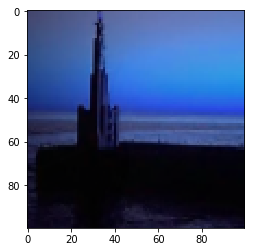

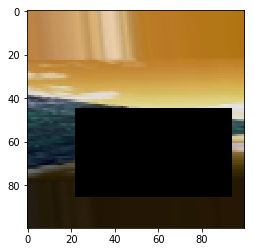

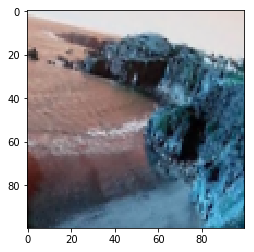

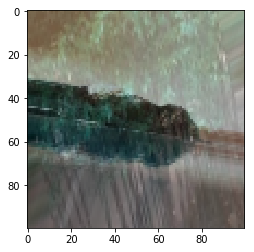

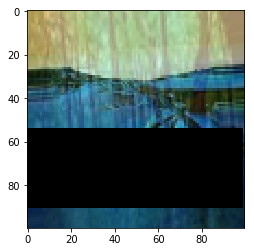

In [4]:
# Downloading and Viewing the dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

def load():
    f = h5py.File("dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()

horizontal_flip=True
vertical_flip=True
zoom_range=[0.5, 1.9]
rotation_range=20
shear_range=0.2
channel_shift_range=5.
brightness_range=[0.3, 1.0]
# custom param
mix_up_alpha=0.2# mixup alpha
#random_crop=[80,80]# random_crop size
random_erasing_prob=0.5 # random_erasing 確率

datagen = my_generator.MyImageDataGenerator(
    rescale=1.0,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=horizontal_flip,  # randomly flip images
    #vertical_flip=vertical_flip,  # randomly flip images
    shear_range = shear_range,
    zoom_range=zoom_range,
    ##brightness_range=brightness_range,
    ##channel_shift_range=channel_shift_range,
    mix_up_alpha=mix_up_alpha, 
    #random_crop=random_crop, 
    random_erasing_prob=random_erasing_prob,
    random_erasing_maxpixel=1.0
)

val_datagen = my_generator.MyImageDataGenerator(rescale=1.0)

train_generator = datagen.flow(x_train, y_train, batch_size=train_batch_size)
valid_generator = val_datagen.flow(x_test, y_test, batch_size=valid_batch_size)
X, y = train_generator.__next__()
print(X.shape)
print(y.shape)

for i in range(5):
    plt.imshow(X[i])
    plt.show()

In [5]:
# クラスの不均衡を考慮して、トレーニングデータのclass_weight
class_weight = my_class_weight.cal_weight_flow(y_train)
class_weight

{0: 1.47, 1: 1.31, 2: 1.0, 3: 1.26, 4: 1.1}

## callback

In [6]:
def get_base_cb(plateau = None, base_lr=None, epochs=5, train_batch_size=68, valid_batch_size=37, gpu_count=1):
    out_dir='output_test'
    check_monitor='val_loss' # val_loss最少になるモデルを保存する
    early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
    early_stopping_pati=100
    plateau_monitor='val_loss' # val_lossが100エポック更新されなければ学習率0.9倍
    plateau_pati=100
    plateau_factor=0.9 # plateau_factor=1.0 はエラーになる

    cb = []
    if gpu_count > 1:
        # マルチGPUでModelCheckpoint使うためのコールバック
        weight_dir = os.path.join(out_dir, 'model_weight')
        os.makedirs(weight_dir, exist_ok=True)
        cb.append(my_callback.MyCheckPoint(orig_model, weight_dir))

        # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
        train_batch_size = train_batch_size * gpu_count
        valid_batch_size = valid_batch_size * gpu_count
    else:       
        cb.append(keras.callbacks.TerminateOnNaN())
        #cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(out_dir, 'test_sample_data_model.h5'), monitor=check_monitor, save_best_only=True, verbose=1))#, monitor='val_acc'
        cb.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati, verbose=1))
        
        if plateau != None:
            # ReduceLROnPlateau つけないと学習率csvファイルに記録されない
            plateau = keras.callbacks.ReduceLROnPlateau(
                        monitor=plateau_monitor, # モデルの検証データセットでの損失値を監視
                        factor=plateau_factor, # コールバックが起動したら学習率をplateau_factor掛ける
                        patience=plateau_pati # 検証データでの損失値がplateauエポックにわたって改善しなかった場合はコールバックを起動
                        )
            cb.append(plateau)
        if base_lr != None:
            base_lr = 0.1 * train_batch_size / 128  # adamとかなら1e-3くらい。SGDなら例えば 0.1 * batch_size / 128 とかくらい。nadamなら0.002*10 ?
            lr_decay_rate = 1 / 3
            lr_steps = 4
            cb.append(keras.callbacks.LearningRateScheduler(lambda ep: float(base_lr * lr_decay_rate ** (ep * lr_steps // epochs))))

    return cb

## model.fit_generator(No_branch)

### SEDenseNet

In [9]:
epochs=1
cb0 = get_base_cb()
cb0.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data.tsv'), separator='\t'))
print(cb0)

choice_model_list=['SEDenseNet']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
sedensenet_num_list=[264]# [121,161,169,201,264]
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for sedensenet_num in sedensenet_num_list:
        for FCnum in FCnum_list:
            for activation in activation_list:
                print('\n###################################')
                model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                        , choice_model, trainable
                                                                        , FCnum
                                                                        , FCpool=FCpool
                                                                        , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                        , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                        , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                        , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                        , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                        , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                        , activation=activation 
                                                                        , gpu_count=gpu_count
                                                                        , skip_bn=skip_bn
                                                                        , sedensenet_num=sedensenet_num
                                                                      )
                for opt in opt_list:
                    # オプティマイザ
                    optim = define_model.get_optimizers(opt, decay=0.001)
                    # モデルコンパイル
                    model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                                  , optimizer=optim
                                  , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])

                model.fit_generator(train_generator
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=valid_generator
                                    , validation_steps=x_test.shape[0] // valid_batch_size
                                    , callbacks=cb0
                                    , verbose=1)

[<keras.callbacks.TerminateOnNaN object at 0x000002DB0B1DB908>, <keras.callbacks.EarlyStopping object at 0x000002DB0B1CB828>, <keras.callbacks.CSVLogger object at 0x000002DB0B21A0F0>]

###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = SEDenseNet all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
sedensenet_num = 264
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/1
160/160 [==============================] - 85s 532ms/step - loss: 3.3133 - acc: 0.3669 - binary_accuracy: 0.5594 - masked_accuracy: 0.5594 - val_loss: 5.7741 - val_acc: 0.2125 - val_binary_accuracy: 0.6120 - val_masked_accuracy: 0.6120


### NASNetLarge

In [5]:
cb0 = get_base_cb()
cb0.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data.tsv'), separator='\t'))
print(cb0)

choice_model_list=['NASNetLarge']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[5]# [None,1,2,3,4,5]
opt_list=['adagrad']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.001)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])
                
            model.fit_generator(train_generator
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=valid_generator
                                    , validation_steps=x_test.shape[0] // valid_batch_size
                                    , callbacks=cb0
                                    , verbose=1)

[<keras.callbacks.TerminateOnNaN object at 0x000002B67504C1D0>, <keras.callbacks.EarlyStopping object at 0x000002B67504C208>, <keras.callbacks.CSVLogger object at 0x000002B67504C198>]

###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = NASNetLarge all
FCnum = 5
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


C:\Users\shingo\Anaconda3\envs\tfgpu_py36\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 512 0.5 None he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 256 0.5 None he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 128 0.5 None he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 64 0.5 None he_normal 0.0001
---- choice_optim = adagrad ----
adagrad_lr adagrad_decay = 0.01 0.001
Epoch 1/5
160/160 [==============================] - 117s 729ms/step - loss: 1.2981 - acc: 0.2025 - binary_accuracy: 0.5658 - masked_accuracy: 0.5658 - val_loss: 1.2988 - val_acc: 0.2700 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 2/5
160/160 [==============================] - 61s 382ms/step - loss: 1.0557 - acc: 0.2381 - binary_accuracy: 0.5701 - masked_accuracy: 0.5701 - val_loss: 1.4811 - val_acc: 0.2750 - val_binary_accuracy: 0.7615 - val_masked_ac

## my_callback.learning_curve_plot
- epochごとに学習曲線保存する自作callback

[<keras.callbacks.TerminateOnNaN object at 0x000001E5F9234C18>, <keras.callbacks.EarlyStopping object at 0x000001E5F9234AC8>, <model.my_callback.learning_curve_plot.<locals>._LearningCurvePlotter object at 0x000001E5F6DA8D68>]

###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
add_se = False
----- FC_layer -----
[<keras.callbacks.TerminateOnNaN object at 0x000001E5F9234C18>, <keras.callbacks.EarlyStopping object at 0x000001E5F9234AC8>, <model.my_callback.learning_curve_plot.<locals>._LearningCurvePlotter object at 0x000001E5F6DA8D68>, <model.my_callback.MyCheckPoint object at 0x000001E5FA682C88>]
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/1
160/160 [===

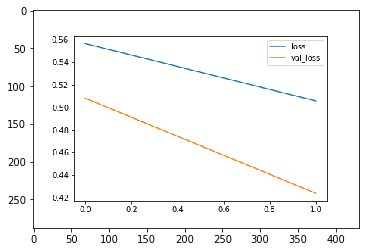

In [7]:
cb0 = get_base_cb()
cb0.append(my_callback.learning_curve_plot(os.path.join(out_dir, 'learning_curve.png')))
print(cb0)

choice_model_list=['VGG16']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            
            # MyCheckPoint テスト
            weight_dir = os.path.join(out_dir, 'model_weight')
            os.makedirs(weight_dir, exist_ok=True)
            cb0.append(my_callback.MyCheckPoint(model, weight_dir))
            print(cb0)
            
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.001)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=1
                                , validation_data=(x_test, y_test)
                                , callbacks=cb0
                                , verbose=1)

util.show_file_img(os.path.join(out_dir, 'learning_curve.png'))

## my_callback.MyCheckPoint
- epochごとにモデル保存する自作callback

### 引数 snapshots_epoch なし

In [35]:
cb0 = get_base_cb()
cb0.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data.tsv'), separator='\t'))

choice_model_list=['VGG16']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            
            # MyCheckPoint テスト
            weight_dir = os.path.join(out_dir, 'model_weight')
            os.makedirs(weight_dir, exist_ok=True)
            cb0.append(my_callback.MyCheckPoint(model, weight_dir))
            print(cb0)
            
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.001)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=1
                                , validation_data=(x_test, y_test)
                                , callbacks=cb0
                                , verbose=1)

# 出力層のニューラルネットワークに分岐がない場合のpredict
trained_model = keras.models.load_model(os.path.join(out_dir, 'model_weight', 'model_at_epoch_1.h5'), compile=False)
out_predict_dir = os.path.join(out_dir, 'predict/sample_data')
y_test_list, y_pred_list = multi_predict.no_branch_set_predict(trained_model, x_test, y_test, out_predict_dir)


###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
----- FC_layer -----
[<keras.callbacks.TerminateOnNaN object at 0x000002DD07E50828>, <keras.callbacks.EarlyStopping object at 0x000002DD07E506A0>, <keras.callbacks.CSVLogger object at 0x000002DF2B339E48>, <model.my_callback.MyCheckPoint object at 0x000002DEA8D2AF28>]
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/1
160/160 [==============================] - 77s 484ms/step - loss: 0.4873 - acc: 0.4369 - binary_accuracy: 0.5780 - masked_accuracy: 0.5780 - val_loss: 0.3353 - val_acc: 0.6625 - val_binary_accuracy: 0.8515 - val_masked_accuracy: 0.8515


### 引数 snapshots_epoch あり。5epochごとにモデルsave

In [36]:
cb0 = get_base_cb()
cb0.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data.tsv'), separator='\t'))

choice_model_list=['SEResNet']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                   , seresnet_num=18
                                                                  )
            
            # MyCheckPoint テスト
            weight_dir = os.path.join(out_dir, 'model_weight')
            os.makedirs(weight_dir, exist_ok=True)
            cb0.append(my_callback.MyCheckPoint(model, weight_dir, snapshots_epoch=5))
            print(cb0)
            
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.001)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=10
                                , validation_data=(x_test, y_test)
                                , callbacks=cb0
                                , verbose=1)

# 出力層のニューラルネットワークに分岐がない場合のpredict
trained_model = keras.models.load_model(os.path.join(out_dir, 'model_weight', 'model_at_epoch_9.h5'), compile=False)
out_predict_dir = os.path.join(out_dir, 'predict/sample_data')
y_test_list, y_pred_list = multi_predict.no_branch_set_predict(trained_model, x_test, y_test, out_predict_dir)


###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = SEResNet all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
seresnet_num = 18
----- FC_layer -----
[<keras.callbacks.TerminateOnNaN object at 0x000002DF84389C18>, <keras.callbacks.EarlyStopping object at 0x000002DF84389BE0>, <keras.callbacks.CSVLogger object at 0x000002DEA8D2AF28>, <model.my_callback.MyCheckPoint object at 0x000002DFFB2885C0>]
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/10
160/160 [==============================] - 79s 496ms/step - loss: 0.5361 - acc: 0.3275 - binary_accuracy: 0.5760 - masked_accuracy: 0.5760 - val_loss: 0.4461 - val_acc: 0.4600 - val_binary_accuracy: 0.7945 - val_masked_accuracy: 0.7945
Epoch 2/10
160/160 [===================

## my_callback.tsv_logger
- 自作学習ログ出力callback

In [8]:
cb0 = get_base_cb()
cb0.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data.tsv'), separator='\t'))

# my_callback.tsv_logger テスト
cb0.append(my_callback.tsv_logger(os.path.join(out_dir, 'tsv_logger.tsv')))

choice_model_list=['VGG16']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            
            # MyCheckPoint テスト
            weight_dir = os.path.join(out_dir, 'model_weight')
            os.makedirs(weight_dir, exist_ok=True)
            cb0.append(my_callback.MyCheckPoint(model, weight_dir, snapshots_epoch=5))
            print(cb0)
            
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.001)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=10
                                , validation_data=(x_test, y_test)
                                , callbacks=cb0
                                , verbose=1)

# 出力層のニューラルネットワークに分岐がない場合のpredict
trained_model = keras.models.load_model(os.path.join(out_dir, 'model_weight', 'model_at_epoch_9.h5'), compile=False)
out_predict_dir = os.path.join(out_dir, 'predict/sample_data')
y_test_list, y_pred_list = multi_predict.no_branch_set_predict(trained_model, x_test, y_test, out_predict_dir)


###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
[<keras.callbacks.TerminateOnNaN object at 0x7f7851aed160>, <keras.callbacks.EarlyStopping object at 0x7f7851aed198>, <keras.callbacks.CSVLogger object at 0x7f7853eaf208>, <model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x7f7851d3c2b0>, <model.my_callback.MyCheckPoint object at 0x7f78514a95f8>]
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/10
23/23 [==============================] - 21s 916ms/step - loss: 0.5725 - acc: 0.2838 - binary_accuracy: 0.7524 - masked_accuracy: 0.7524 - val_loss: 0.5423 - val_acc: 0.4025 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 2/10
23/23 [==============================] - 13s 554ms/step - loss: 0.4917 - acc: 0.3919 - binary_accuracy: 0.7726 - masked_accuracy: 0.7726 - val_loss: 0.4348 - val_acc: 0.5500 - val_binary_accuracy: 0.7995 - val_masked_accuracy: 0.7995
Epoch 3/10
23/23 [==============================] - 13s 555ms/step - loss: 0.4245 - acc

## my_metric.get_lr_metric
- stepごとにlrを表示させるメトリック

### 学習率書く場合はmy_metric.get_lr_metricだけで良い
<font color="Red">
    
### ただし、オリジナルmetric入れたらモデルロード時に custom_objects を宣言しないとエラーになる¶
- model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
</font>

In [9]:
cb1 = get_base_cb()
cb1.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data_lr_metric.tsv'), separator='\t'))
print(cb1)

choice_model_list=['InceptionV3']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.001)
                lr_metric = my_metric.get_lr_metric(optim)# コールバックで下げたlrは表示されない。あくまでそのエポックの初期学習率をエポックごとに表示する
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy, lr_metric])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=epochs
                                , validation_data=(x_test, y_test)
                                , callbacks=cb1
                                , verbose=1)

[<keras.callbacks.TerminateOnNaN object at 0x7f78528e86d8>, <keras.callbacks.EarlyStopping object at 0x7f78528e8b70>, <keras.callbacks.CSVLogger object at 0x7f78528e88d0>]

###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = InceptionV3 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/5
23/23 [==============================] - 23s 979ms/step - loss: 0.5885 - acc: 0.2903 - binary_accuracy: 0.7518 - masked_accuracy: 0.7518 - lr: 0.0100 - val_loss: 0.6145 - val_acc: 0.2450 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525 - val_lr: 0.0100
Epoch 2/5
23/23 [==============================] - 9s 393ms/step - loss: 0.5347 - acc: 0.3464 - binary_accuracy: 0.7554 - masked_accuracy: 0.7554 - lr: 0.0100 - val_loss: 0.5352 - val_acc: 0.4200 - val_binary_accuracy: 0.7585 - val_masked_accuracy: 0.7585 - val_lr: 0.0100
Epoch 3/5
23/23 [==============================] - 9s 393ms/step - loss: 0.5006 - acc: 0.3911 - binary_accuracy: 0.7652 - masked_accuracy: 0.7652 - lr: 0.0100 - val_loss: 0.4857 - val_acc: 0.4850 - val_binary_accuracy: 0.7830 - val_masked_accuracy: 0.7830 - val_lr: 0.0100
Epoch 4/5
23/23 [==============================] - 9s 401ms/step 

## my_callback.LossHistory
- epochごとにlrを表示させるcallback

### history_sample_data_LossHistory.tsv にはlr記載されない

In [10]:
cb2 = get_base_cb()
# callbackで学習率表示
loss_history = my_callback.LossHistory()
cb2.append(loss_history)
cb2.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data_LossHistory.tsv'), separator='\t'))
print(cb2)

choice_model_list=['VGG16']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[1]# [None,1,2,3,4,5]
opt_list=['adam']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=epochs
                                , validation_data=(x_test, y_test)
                                , callbacks=cb2
                                , verbose=1)

[<keras.callbacks.TerminateOnNaN object at 0x7f786835c4e0>, <keras.callbacks.EarlyStopping object at 0x7f786835c7f0>, <model.my_callback.LossHistory object at 0x7f786835c780>, <keras.callbacks.CSVLogger object at 0x7f7868a78048>]

###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = 1
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 1024 0.5 None he_normal 0.0001
---- choice_optim = adam ----
adam_lr adam_decay beta_1 beta_2 = 0.001 0.0 0.9 0.999
Epoch 1/5
22/23 [===========================>..] - ETA: 0s - loss: 3.8128 - acc: 0.2047 - binary_accuracy: 0.7522 - masked_accuracy: 0.7522
lr: 0.1
23/23 [==============================] - 23s 978ms/step - loss: 3.8233 - acc: 0.2054 - binary_accuracy: 0.7522 - masked_accuracy: 0.7522 - val_loss: 4.0715 - val_acc: 0.2100 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 2/5
22/23 [===========================>..] - ETA: 0s - loss: 4.0501 - acc: 0.2039 - binary_accuracy: 0.7524 - masked_accuracy: 0.7524
lr: 0.1
23/23 [==============================] - 13s 558ms/step - loss: 4.0425 - acc: 0.2039 - binary_accuracy: 0.7529 - masked_accuracy: 0.7529 - val_loss: 4.0280 - val_acc: 0.2100 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 3/5
22/23 [==========================

## my_callback.cosine_annealing
- 学習率をエポック増やすごとにコサインカーブのように上げ下げする
- 引数なしならlr*0.01されるだけ
### 引数なし

[<keras.callbacks.TerminateOnNaN object at 0x7f783259db00>, <keras.callbacks.EarlyStopping object at 0x7f783259dac8>, <model.my_callback.cosine_annealing.<locals>._CosineAnnealing object at 0x7f783259da90>, <keras.callbacks.CSVLogger object at 0x7f783259d978>]

###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
Epoch 1/10
23/23 [==============================] - 15s 654ms/step - loss: 0.5737 - acc: 0.2608 - binary_accuracy: 0.7526 - masked_accuracy: 0.7526 - lr: 0.0098 - val_loss: 0.5483 - val_acc: 0.2425 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525 - val_lr: 0.0098
Epoch 2/10
23/23 [==============================] - 13s 551ms/step - loss: 0.5015 - acc: 0.3797 - binary_accuracy: 0.7685 - masked_accuracy: 0.7685 - lr: 0.0091 - val_loss: 0.3969 - val_acc: 0.5475 - val_binary_accuracy: 0.8305 - val_masked_accuracy: 0.8305 - val_lr: 0.0091
Epoch 3/10
23/23 [==============================] - 13s 562ms/step - loss: 0.3990 - acc: 0.5288 - binary_accuracy: 0.8125 - masked_accuracy: 0.8125 - lr: 0.0080 - val_loss: 0.3138 - val_acc: 0.7000 - val_binary_accuracy: 0.8765 - val_masked_accuracy: 0.8765 - val_lr: 0.0080
Epoch 4/10
23/23 [==============================] - 13s 553ms/

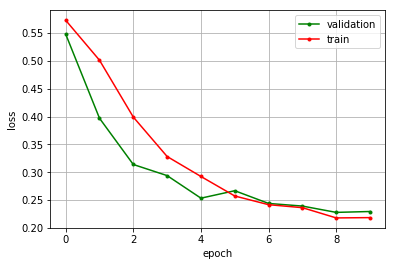

<Figure size 432x288 with 0 Axes>

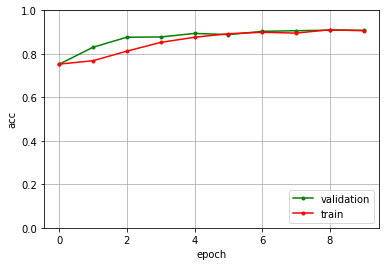

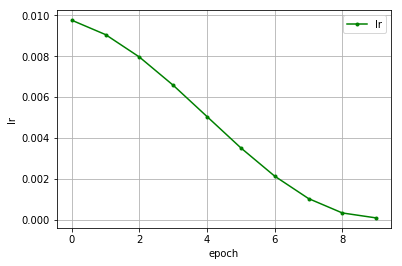

<Figure size 432x288 with 0 Axes>

In [11]:
epochs=10
cb3 = get_base_cb()
# 学習率をエポック増やすごとにコサインカーブのように上げ下げする
## 引数なしならlr*0.01されるだけ
cb3.append(my_callback.cosine_annealing())
cb3.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data_cosine_annealing.tsv'), separator='\t'))
print(cb3)

choice_model_list=['VGG16']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt)
                lr_metric = my_metric.get_lr_metric(optim)# コールバックで下げたlrは表示されない。あくまでそのエポックの初期学習率をエポックごとに表示する
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy, lr_metric])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=epochs
                                , validation_data=(x_test, y_test)
                                , callbacks=cb3
                                , verbose=1)
            
%matplotlib inline
plot_log.plot_results(out_dir, os.path.join(out_dir, 'history_sample_data_cosine_annealing.tsv'))

### 引数: epochs=epochs//3

[<keras.callbacks.TerminateOnNaN object at 0x7f151e8d1828>, <keras.callbacks.EarlyStopping object at 0x7f151e8d1278>, <model.my_callback.cosine_annealing.<locals>._CosineAnnealing object at 0x7f15745bf940>, <keras.callbacks.CSVLogger object at 0x7f1574480160>]

###################################
----- model_param -----
output_dir = output_test
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
choice_optim = sgd
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/10
23/23 [==============================] - 14s 596ms/step - loss: 0.5784 - acc: 0.2847 - binary_accuracy: 0.7519 - masked_accuracy: 0.7519 - lr: 0.0075 - val_loss: 0.5508 - val_acc: 0.2400 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525 - val_lr: 0.0075
Epoch 2/10
23/23 [==============================] - 14s 590ms/step - loss: 0.5391 - acc: 0.3563 - binary_accuracy: 0.7531 - masked_accuracy: 0.7531 - lr: 0.0026 - val_loss: 0.5198 - val_acc: 0.4750 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525 - val_lr: 0.0026
Epoch 3/10
23/23 [==============================] - 14s 601ms/step - loss: 0.5148 - acc: 0.3088 - binary_accuracy: 0.7692 - masked_accuracy: 0.7692 - lr: 1.0000e-04 - val_loss: 0.5012 - val_acc: 0.4400 - val_binary_accuracy: 0.7580 - val_masked_accuracy: 0.7580 - val_lr: 1.0000e-04
Epoch 4/10
23/23 [==============================] - 13s 580ms/

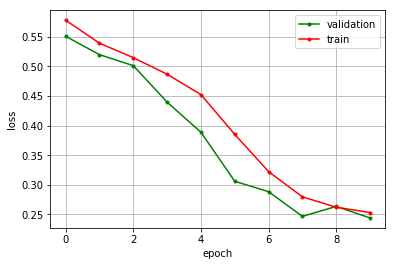

<Figure size 432x288 with 0 Axes>

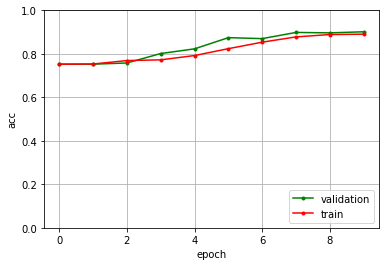

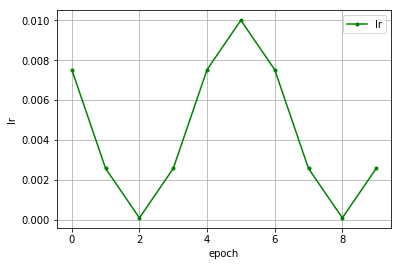

<Figure size 432x288 with 0 Axes>

In [10]:
epochs=10
cb3_1 = get_base_cb()
# 学習率をエポック増やすごとにコサインカーブのように上げ下げする
## 引数なしならlr*0.01されるだけ
cb3_1.append(my_callback.cosine_annealing(epochs=epochs//3))
cb3_1.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data_cosine_annealing.tsv'), separator='\t'))
print(cb3_1)

choice_model_list=['VGG16']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt)
                lr_metric = my_metric.get_lr_metric(optim)# コールバックで下げたlrは表示されない。あくまでそのエポックの初期学習率をエポックごとに表示する
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy, lr_metric])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=epochs
                                , validation_data=(x_test, y_test)
                                , callbacks=cb3_1
                                , verbose=1)
%matplotlib inline
plot_log.plot_results(out_dir, os.path.join(out_dir, 'history_sample_data_cosine_annealing.tsv'))

### 引数: epochs=epochs//2

[<keras.callbacks.TerminateOnNaN object at 0x7f14e9028e80>, <keras.callbacks.EarlyStopping object at 0x7f14e9028ef0>, <model.my_callback.cosine_annealing.<locals>._CosineAnnealing object at 0x7f14e9028eb8>, <keras.callbacks.CSVLogger object at 0x7f14e9028f98>]

###################################
----- model_param -----
output_dir = output_test
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


/home/tmp10014/.conda/envs/py36/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
choice_optim = sgd
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/10
23/23 [==============================] - 15s 652ms/step - loss: 0.5721 - acc: 0.3054 - binary_accuracy: 0.7530 - masked_accuracy: 0.7530 - lr: 0.0091 - val_loss: 0.5485 - val_acc: 0.2525 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525 - val_lr: 0.0091
Epoch 2/10
23/23 [==============================] - 14s 597ms/step - loss: 0.5076 - acc: 0.3688 - binary_accuracy: 0.7655 - masked_accuracy: 0.7655 - lr: 0.0066 - val_loss: 0.4209 - val_acc: 0.5175 - val_binary_accuracy: 0.8135 - val_masked_accuracy: 0.8135 - val_lr: 0.0066
Epoch 3/10
23/23 [==============================] - 14s 601ms/step - loss: 0.4053 - acc: 0.5306 - binary_accuracy: 0.8148 - masked_accuracy: 0.8148 - lr: 0.0035 - val_loss: 0.3307 - val_acc: 0.6250 - val_binary_accuracy: 0.8505 - val_masked_accuracy: 0.8505 - val_lr: 0.0035
Epoch 4/10
23/23 [==============================] - 14s 603ms/step - l

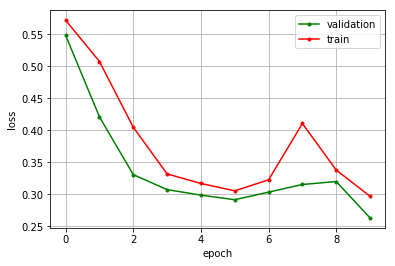

<Figure size 432x288 with 0 Axes>

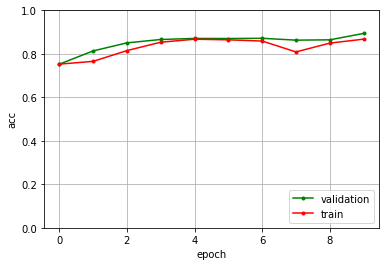

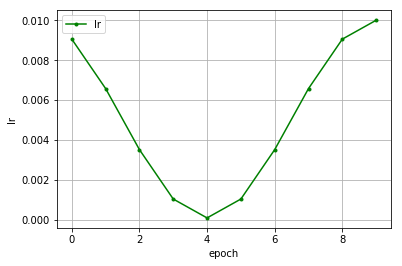

<Figure size 432x288 with 0 Axes>

In [12]:
epochs=10
cb3_2 = get_base_cb()
# 学習率をエポック増やすごとにコサインカーブのように上げ下げする
## 引数なしならlr*0.01されるだけ
cb3_2.append(my_callback.cosine_annealing(epochs=epochs//2))
cb3_2.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data_cosine_annealing.tsv'), separator='\t'))
print(cb3_2)

choice_model_list=['VGG16']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt)
                lr_metric = my_metric.get_lr_metric(optim)# コールバックで下げたlrは表示されない。あくまでそのエポックの初期学習率をエポックごとに表示する
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy, lr_metric])
                
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                , steps_per_epoch=x_train.shape[0] // train_batch_size
                                , epochs=epochs
                                , validation_data=(x_test, y_test)
                                , callbacks=cb3_2
                                , verbose=1)
%matplotlib inline
plot_log.plot_results(out_dir, os.path.join(out_dir, 'history_sample_data_cosine_annealing.tsv'))

## model.fit_generator(12branch)
- ニューラルネットワークを分岐させてMulti-task learningのときに使うもの

In [14]:
# 5つの出力（task）をだすgeneratorにする
def generator_5output(generator):
    while True:
        X_y = generator.__next__()
        X = X_y[0]
        y = X_y[1]
        # 入力画素(X1[0]), 5taskのラベルのリスト([X1[0], X2[1], X3[1]]…)
        yield X, [y[:,0], y[:,1], y[:,2], y[:,3], y[:,4]]
        
gen = datagen.flow(x_train, y_train, batch_size=train_batch_size)

In [15]:
epochs=1
cb4 = get_base_cb(plateau=True, base_lr=True)
cb4.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data_5branch.tsv'), separator='\t'))
print(cb4)

choice_model_list=['SEInceptionResNetV2']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['rmsprop']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_12branch_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.0)
                lr_metric = my_metric.get_lr_metric(optim)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy, lr_metric])
                
                
                model.fit_generator(generator_5output(gen)
                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                    , epochs=epochs
                    , validation_data=(x_test, [y_test[:,0], y_test[:,1], y_test[:,2], y_test[:,3], y_test[:,4]])
                    , callbacks=cb4
                    , verbose=1)

[<keras.callbacks.TerminateOnNaN object at 0x000002DB0BB6CE48>, <keras.callbacks.EarlyStopping object at 0x000002DB0BB6CB38>, <keras.callbacks.ReduceLROnPlateau object at 0x000002DB0BB6CEB8>, <keras.callbacks.LearningRateScheduler object at 0x000002DB0BB6CA20>, <keras.callbacks.CSVLogger object at 0x000002DB0BB6C9B0>]

###################################
----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = SEInceptionResNetV2 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
----- FC_layer -----
---- choice_optim = rmsprop ----
rmsprop_lr rmsprop_decay rmsprop_rho = 0.001 0.0 0.9
Epoch 1/1
160/160 [==============================] - 87s 542ms/step - loss: 15.6790 - task0_pred_loss: 2.1264 - task1_pred_loss: 2.7178 - task2_

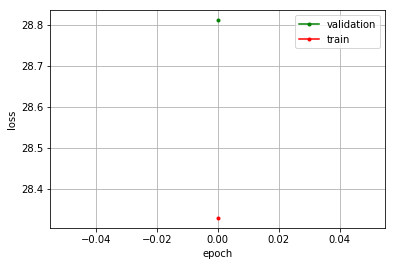

<Figure size 432x288 with 0 Axes>

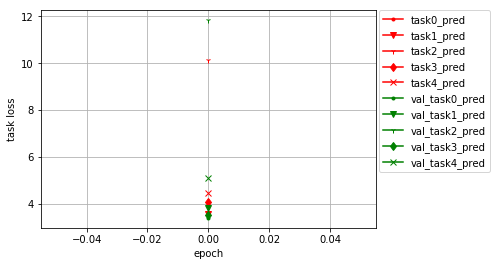

<Figure size 432x288 with 0 Axes>

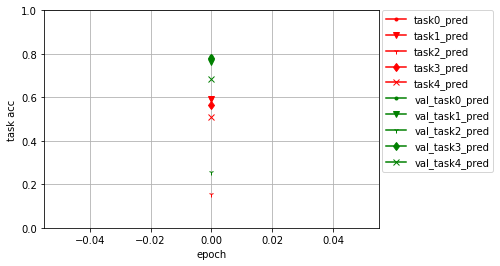

<Figure size 432x288 with 0 Axes>

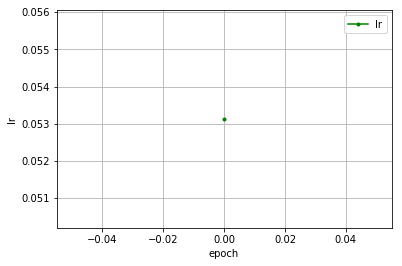

<Figure size 432x288 with 0 Axes>

In [16]:
tsv_col = ['task0_pred', 'task1_pred', 'task2_pred', 'task3_pred', 'task4_pred']
plot_12task_log.plot_results(out_dir, os.path.join(out_dir, 'history_sample_data_5branch.tsv'), tsv_col=tsv_col)

## 画像サイズまちまちの画像ファイルのデータ
- https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [25]:
num_classes = 6
classes = ['black_jeans', 'blue_dress', 'blue_jeans', 'blue_shirt', 'red_dress', 'red_shirt']
train_data_dir = r'D:\work\keras-multi-label\keras-multi-label\keras-multi-label\dataset'
train_batch_size=3#68#17
valid_batch_size=valid_batch_size#37#6
shape=[331, 331, 3]
epochs=2
out_dir='output_test/331x331'
gpu_count=1

horizontal_flip=True
vertical_flip=True
zoom_range=[0.5, 1.9]
rotation_range=20
shear_range=0.2
channel_shift_range=5.
brightness_range=[0.3, 1.0]
# custom param
mix_up_alpha=0.2# mixup alpha
#random_crop=[80,80]# random_crop size
random_erasing_prob=0.5 # random_erasing 確率

datagen = my_generator.MyImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=horizontal_flip,  # randomly flip images
    #vertical_flip=vertical_flip,  # randomly flip images
    shear_range = shear_range,
    zoom_range=zoom_range,
    ##brightness_range=brightness_range,
    ##channel_shift_range=channel_shift_range,
    mix_up_alpha=mix_up_alpha, 
    #random_crop=random_crop, 
    random_erasing_prob=random_erasing_prob,
    random_erasing_maxpixel=1.0
)
valid_datagen = my_generator.get_datagen(rescale=1.0/255.0)

In [26]:
train_generator = datagen.flow_from_directory(
    train_data_dir, # ラベルクラスをディレクトリ名にした画像ディレクトリのパス
    target_size=(shape[0], shape[1]), # すべての画像はこのサイズにリサイズ
    color_mode='rgb',# 画像にカラーチャンネルが3つある場合は「rgb」画像が白黒またはグレースケールの場合は「grayscale」
    classes=classes, # 分類クラス数 
    class_mode='categorical', # 2値分類は「binary」、多クラス分類は「categorical」
    batch_size=train_batch_size, # バッチごとにジェネレータから生成される画像の数
    shuffle=True # 生成されているイメージの順序をシャッフルする場合は「True」を設定し、それ以外の場合は「False」。train set は基本入れ替える
)

validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(shape[0], shape[1]),
    color_mode='rgb',
    classes=classes,
    class_mode='categorical',
    batch_size=train_batch_size,# batch_size はセット内の画像の総数を正確に割るような数に設定しないと同じ画像を2回使うため、validation やtest setのbatch size は割り切れる数にすること！！！
    shuffle=False# validation/test set は基本順番入れ替えない
)

Found 2165 images belonging to 6 classes.


(3, 331, 331, 3)
(3, 6)


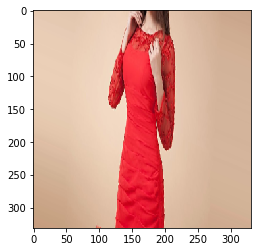

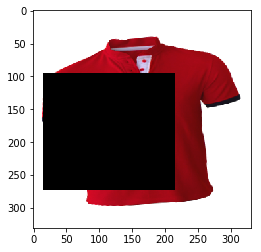

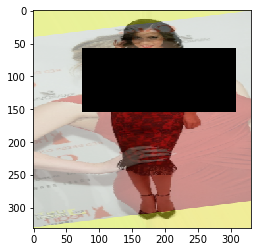

In [28]:
X, y = train_generator.__next__()
print(X.shape)
print(y.shape)

for i in range(3):
    plt.imshow(X[i])
    plt.show()

In [29]:
next(train_generator)

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

### ResNet50
- ResNet50 は100x100では小さすぎてエラー。331x331ならセーフ

In [23]:
cb0 = get_base_cb()
cb0.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data.tsv'), separator='\t'))
print(cb0)

# ResNet50 は100x100では小さすぎてエラー
choice_model_list=['ResNet50']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for FCnum in FCnum_list:
        for activation in activation_list:
            print('\n###################################')
            model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                    , choice_model, trainable
                                                                    , FCnum
                                                                    , FCpool=FCpool
                                                                    , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                    , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                    , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                    , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                    , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                    , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                    , activation=activation 
                                                                    , gpu_count=gpu_count
                                                                    , skip_bn=skip_bn
                                                                  )
            for opt in opt_list:
                # オプティマイザ
                optim = define_model.get_optimizers(opt, decay=0.001)
                # モデルコンパイル
                model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                              , optimizer=optim
                              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])
                
            model.fit_generator(train_generator
                                    , steps_per_epoch=2165 // train_batch_size
                                    , epochs=epochs
                                    , validation_data=validation_generator
                                    , validation_steps=2165 // valid_batch_size
                                    , callbacks=cb0
                                    , verbose=1)

[<keras.callbacks.TerminateOnNaN object at 0x000002DD0BB5D550>, <keras.callbacks.EarlyStopping object at 0x000002DD0BB5D588>, <keras.callbacks.CSVLogger object at 0x000002DD0C170F60>]

###################################
----- model_param -----
output_dir = output_test/331x331
img_rows img_cols channels = 331 331 3
num_classes = 6
choice_model trainable = ResNet50 all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/2
 80/216 [==========>...................] - ETA: 3:05 - loss: 0.2830 - acc: 0.7000 - binary_accuracy: 0.7021 - masked_accuracy: 0.7021

C:\Users\shingo\Anaconda3\envs\tfgpu_py36\lib\site-packages\PIL\Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


216/216 [==============================] - 343s 2s/step - loss: 0.2210 - acc: 0.7884 - binary_accuracy: 0.7082 - masked_accuracy: 0.7082 - val_loss: 0.0570 - val_acc: 0.9583 - val_binary_accuracy: 0.9831 - val_masked_accuracy: 0.9831
Epoch 2/2
216/216 [==============================] - 300s 1s/step - loss: 0.1637 - acc: 0.8722 - binary_accuracy: 0.7143 - masked_accuracy: 0.7143 - val_loss: 0.0284 - val_acc: 0.9773 - val_binary_accuracy: 0.9915 - val_masked_accuracy: 0.9915


### SEResNext
- 331x331ならエラーにならない

In [31]:
epochs=2
cb0 = get_base_cb()
cb0.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history_sample_data.tsv'), separator='\t'))
print(cb0)

choice_model_list=['SEResNext']# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
seresnext_num_list=[50,101]
FCnum_list=[None]# [None,1,2,3,4,5]
opt_list=['sgd']# ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

for choice_model in choice_model_list:
    for seresnext_num in seresnext_num_list:
        for FCnum in FCnum_list:
            for activation in activation_list:
                print('\n###################################')
                model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                                        , choice_model, trainable
                                                                        , FCnum
                                                                        , FCpool=FCpool
                                                                        , Dence_1=Dence_1, Dropout_1=Dropout_1, addBatchNorm_1=addBatchNorm_1, kernel_initializer_1=kernel_initializer_1, l2_rate_1=l2_rate_1
                                                                        , Dence_2=Dence_2, Dropout_2=Dropout_2, addBatchNorm_2=addBatchNorm_2, kernel_initializer_2=kernel_initializer_2, l2_rate_2=l2_rate_2
                                                                        , Dence_3=Dence_3, Dropout_3=Dropout_3, addBatchNorm_3=addBatchNorm_3, kernel_initializer_3=kernel_initializer_3, l2_rate_3=l2_rate_3
                                                                        , Dence_4=Dence_4, Dropout_4=Dropout_4, addBatchNorm_4=addBatchNorm_4, kernel_initializer_4=kernel_initializer_4, l2_rate_4=l2_rate_4
                                                                        , Dence_5=Dence_5, Dropout_5=Dropout_5, addBatchNorm_5=addBatchNorm_5, kernel_initializer_5=kernel_initializer_5, l2_rate_5=l2_rate_5
                                                                        , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                                        , activation=activation 
                                                                        , gpu_count=gpu_count
                                                                        , skip_bn=skip_bn
                                                                        , seresnext_num=seresnext_num
                                                                      )
                for opt in opt_list:
                    # オプティマイザ
                    optim = define_model.get_optimizers(opt, decay=0.001)
                    # モデルコンパイル
                    model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
                                  , optimizer=optim
                                  , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])

                model.fit_generator(train_generator
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=1
                                    , validation_data=validation_generator
                                    , validation_steps=x_test.shape[0] // valid_batch_size
                                    , callbacks=cb0
                                    , verbose=1)

[<keras.callbacks.TerminateOnNaN object at 0x000002DF2B339F28>, <keras.callbacks.EarlyStopping object at 0x000002DF2B339E48>, <keras.callbacks.CSVLogger object at 0x000002DF2B339EB8>]

###################################
----- model_param -----
output_dir = output_test/331x331
img_rows img_cols channels = 331 331 3
num_classes = 6
choice_model trainable = SEResNext all
FCnum = None
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
seresnext_num = 50
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.001 True
Epoch 1/1
533/533 [==============================] - 273s 512ms/step - loss: 25.6595 - acc: 0.3871 - binary_accuracy: 0.6732 - masked_accuracy: 0.6732 - val_loss: 24.3460 - val_acc: 1.0000 - val_binary_accuracy: 0.9903 - val_masked_accuracy: 0.9903

###################################
----- model_param -----
output_dir = output_test/331x331
img_

In [4]:
train_batch_size=10
valid_batch_size=10
shape=[100, 100, 3]

# 入力ディレクトリ
train_data_dir = r'D:\work\AI_Edge_Contest\object_detect\classes\cropped_img_train_val_test_0-5\train'
validation_data_dir = r'D:\work\AI_Edge_Contest\object_detect\classes\cropped_img_train_val_test_0-5\val'
test_dir = r'D:\work\AI_Edge_Contest\object_detect\classes\cropped_img_train_val_test_0-5\test'

# 分類クラス
classes = ['0', '1', '2', '3', '4', '5']

### 訓練画像水増しオプション
# ImageDataGenerator
rescale=1.0/255.0
vertical_flip=True
zoom_range=0.2
rotation_range=20
channel_shift_range=5.
brightness_range=[0.3, 1.0]
# custom param
#mix_up_alpha=0.2# mixup alpha
#random_crop=[224,224]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255

# MyImageDataGenerator のオプションを辞書型で詰める
my_IDG_options={'rescale': rescale
                , 'vertical_flip': vertical_flip
                 , 'zoom_range': zoom_range
                 , 'rotation_range': rotation_range 
                 , 'channel_shift_range': channel_shift_range
                 , 'brightness_range': brightness_range
                 , 'random_erasing_prob': random_erasing_prob
                 , 'random_erasing_maxpixel': random_erasing_maxpixel
               }

d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size
                                            , valid_batch_size=valid_batch_size
                                            , test_batch_size=1)

d_cls.create_my_generator_flow_from_directory(train_data_dir, classes
                                                , valid_data_dir=validation_data_dir, test_data_dir=test_dir
                                                , color_mode='rgb', class_mode='categorical'
                                                , my_IDG_options=my_IDG_options)


Found 47310 images belonging to 6 classes.
Found 23657 images belonging to 6 classes.


(<generator object MyImageDataGenerator.flow_from_directory at 0x0000022F1BB1A2B0>,
 <keras.preprocessing.image.DirectoryIterator at 0x22f1bb22668>)

Found 165580 images belonging to 6 classes.
(10, 100, 100, 3)
(10, 6)
[0. 0. 1. 0. 0. 0.]
['0', '1', '2', '3', '4', '5']


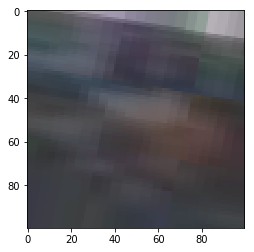

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x,y = next(d_cls.train_gen)
print(x.shape)
print(y.shape)
print(y[0])
print(classes)
plt.imshow(x[0])
plt.show()